IRSA Explainer: https://wise2.ipac.caltech.edu/docs/release/allwise/expsup/sec2_1a.html

Stars within 100 pc of the Sun:  https://www.aanda.org/articles/aa/full_html/2021/05/aa39498-20/aa39498-20.html

LAMOST data cleaning procedure: https://iopscience.iop.org/article/10.3847/1538-4357/acaf5a/pdf
        

In [1]:
from astropy.io import fits
from astropy.table import Table, join, unique

from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.utils.metadata import merge

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


from multiprocessing import set_start_method

plt.style.use('stefan.mplstyle')

In [2]:
catalog = Table.read('data/all_wds.csv')
references = Table.read('data/table_irsa_catalog_search_results.csv')

# Stars from Gaia selected to be within 100pc of the Sun
# source: https://www.aanda.org/articles/aa/full_html/2021/05/aa39498-20/aa39498-20.html
allstars = Table.read('data/allstars.dat.gz', format='ipac')

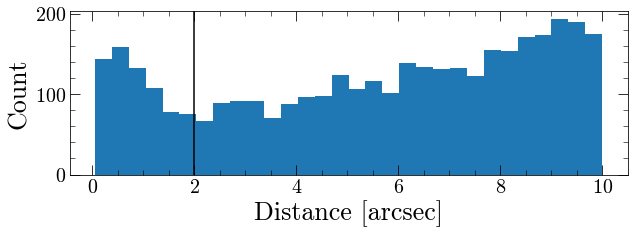

In [3]:
plt.figure(figsize = (10,3))
plt.hist(references['dist_x'], bins = 30)
plt.axvline(x = 2, c = 'k')
plt.xlabel('Distance [arcsec]')
plt.ylabel('Count')

references = references[references['dist_x'] < 2]

In [4]:
catalog = join(left=catalog, right=references, keys_left='CATALOGID', keys_right='catalogid_01', join_type="inner")

(array([ 64., 108.,  90.,  78.,  87.,  62.,  50.,  24.,  25.,  16.,  15.,
          6.,   9.,   8.,   5.,   5.,   3.,   8.,   2.,   2.,   1.,   1.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]),
 array([ 0.56857198,  2.2074055 ,  3.84623901,  5.48507253,  7.12390604,
         8.76273956, 10.40157307, 12.04040658, 13.6792401 , 15.31807361,
        16.95690713, 18.59574064, 20.23457416, 21.87340767, 23.51224118,
        25.1510747 , 26.78990821, 28.42874173, 30.06757524, 31.70640876,
        33.34524227, 34.98407578, 36.6229093 , 38.26174281, 39.90057633,
        41.53940984, 43.17824336, 44.81707687, 46.45591038, 48.0947439 ,
        49.73357741, 51.37241093, 53.01124444, 54.65007796, 56.28891147,
        57.92774498, 59.5665785 , 61.20541201, 62.84424553, 64.48307904,
        66.12191256, 67.76074607, 69.39957958, 71.0384131 , 72.67724661,
       

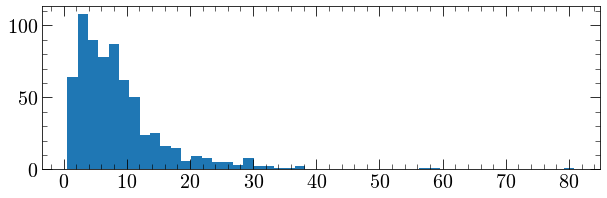

In [5]:
plt.figure(figsize=(10,3))
plt.hist(catalog['PARALLAX'])

In [6]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pyphot
import extinction

catalog['r_med_geo'] = 100 / catalog['PARALLAX']

# Coordinates using inverted parallax distances
coords = [SkyCoord(frame="icrs", ra=catalog['RA'][i]*u.deg, dec=catalog['DEC'][i]*u.deg, distance = catalog['r_med_geo'][i] * u.pc) for i in range(len(catalog))]
catalog['wd_coords'] = coords


# Query Edenhofer2023 to get E(B-V) in arbitrary units
bsq = Edenhofer2023Query()
bsq_res = bsq.query(catalog['wd_coords']).copy()
bsq_res[np.isnan(bsq_res)] = 0

# Convert to actual units
Ebv = bsq_res*0.901*0.98
e_Ebv = Ebv*0.2

catalog['E(B-V)'] = Ebv
catalog['e_E(B-V)'] = e_Ebv


# Parameters for correcting using Gaia
Rv = 3.1
catalog['A_v0'] = catalog['E(B-V)']*Rv

# Fetch Gaia photometric band wavelengths and store in `gaia_phot_wavl`
lib = pyphot.get_library()
gaia_phot = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP']]
gaia_phot_wavl = np.array([x.lpivot.to('angstrom').value for x in gaia_phot])


# For each point, find extinction using the parameters we defined above
ext_all = []
for av0 in catalog['A_v0']:
    ext_all.append( extinction.fitzpatrick99(gaia_phot_wavl, av0, Rv) )
ext_all = np.array(ext_all)
    
# Save the extinction in each band
catalog['BP_ext'] = ext_all.T[0]
catalog['RP_ext'] = ext_all.T[1]

# Subtract out the extinction to find de-reddened magnitude
catalog['GAIA_G'] = catalog['GAIA_G'] - catalog['BP_ext']
catalog['GAIA_BP'] = catalog['GAIA_BP'] - catalog['BP_ext']
catalog['GAIA_RP'] = catalog['GAIA_RP'] - catalog['RP_ext']

Optimizing map for querying (this might take a couple of seconds)...


In [7]:
catalog['abs_g'] = catalog['GAIA_G'] + 5 * np.log10(catalog['PARALLAX'] / 100)
catalog['abs_bp'] = catalog['GAIA_BP'] + 5 * np.log10(catalog['PARALLAX'] / 100)
catalog['abs_rp'] = catalog['GAIA_RP'] + 5 * np.log10(catalog['PARALLAX'] / 100)

catalog['bp_rp'] = catalog['abs_bp'] - catalog['abs_rp']

catalog['abs_w1'] = catalog['w1mpro'] + 5 * np.log10(catalog['PARALLAX'] / 100)
catalog['abs_w2'] = catalog['w2mpro'] + 5 * np.log10(catalog['PARALLAX'] / 100)
catalog['abs_w3'] = catalog['w3mpro'] + 5 * np.log10(catalog['PARALLAX'] / 100)
#catalog['abs_w4'] = catalog['w4mpro'] + 5 * np.log10(catalog['PARALLAX'] / 100)

<ipython-input-7-79cedd1f95bb>:1: RuntimeWarning: divide by zero encountered in log10
  catalog['abs_g'] = catalog['GAIA_G'] + 5 * np.log10(catalog['PARALLAX'] / 100)
<ipython-input-7-79cedd1f95bb>:2: RuntimeWarning: divide by zero encountered in log10
  catalog['abs_bp'] = catalog['GAIA_BP'] + 5 * np.log10(catalog['PARALLAX'] / 100)
<ipython-input-7-79cedd1f95bb>:3: RuntimeWarning: divide by zero encountered in log10
  catalog['abs_rp'] = catalog['GAIA_RP'] + 5 * np.log10(catalog['PARALLAX'] / 100)
<ipython-input-7-79cedd1f95bb>:7: RuntimeWarning: divide by zero encountered in log10
  catalog['abs_w1'] = catalog['w1mpro'] + 5 * np.log10(catalog['PARALLAX'] / 100)
<ipython-input-7-79cedd1f95bb>:8: RuntimeWarning: divide by zero encountered in log10
  catalog['abs_w2'] = catalog['w2mpro'] + 5 * np.log10(catalog['PARALLAX'] / 100)
<ipython-input-7-79cedd1f95bb>:9: RuntimeWarning: divide by zero encountered in log10
  catalog['abs_w3'] = catalog['w3mpro'] + 5 * np.log10(catalog['PARALLAX'

In [ ]:
plt.figure(figsize=(18,7))

plt.subplot(1,2,1)

plt.scatter(allstars['abs_bp'] - allstars['abs_rp'], allstars['abs_g'], c = 'k', alpha = 0.01)
plt.scatter(catalog['abs_bp'] - catalog['abs_rp'], catalog['abs_g'],  c = 'red', alpha = 0.6, marker = 'x', s = 10, label = 'SDSS-V White Dwarfs')

domain = np.linspace(-0.5, 3)
plt.plot(domain, 5*domain+5)

plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel('G')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)

plt.scatter(allstars['abs_bp'] - allstars['abs_rp'], allstars['abs_w1'] - allstars['abs_w2'], c = 'k', alpha = 0.01)
plt.scatter(catalog['abs_bp'] - catalog['abs_rp'], catalog['abs_w1'] - catalog['abs_w2'], c = 'red', alpha = 0.6, marker = 'x', s = 10, label = 'SDSS-V White Dwarfs')

plt.legend(framealpha = 0)

plt.ylim(-2,2)

plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel('W1 - W2')

Text(0, 0.5, 'W1 - W2')

In [ ]:
import sys
sys.path.append('../corv/src')

import pyphot
from pyphot import unit
import corv
import lmfit

base_wavl, tremblay, table = corv.utils.build_montreal_da(path = '/home/sarsene1/corv/src/corv/models/montreal_da', flux_unit = 'flam')

lib = pyphot.get_library()
filters = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP']]

c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16
radius_sun = 6.957e8

def mag_to_flux_spec(mag, filt, e_mag = None):
    if e_mag is not None:
        return (10**( (mag + filt.Vega_zero_mag) / -2.5 ), np.sqrt((-0.921034 * 10**(-0.4 * (mag + filt.Vega_zero_mag)) * e_mag)**2 ))
    else:
        return 10**( (mag + filt.Vega_zero_mag) / -2.5 )

def template(teff, logg, radius, distance):
    fl = tremblay((teff, logg))
    
    radius = radius * radius_sun # Rsun to meter
    distance = distance * pc_to_m # Parsec to meter
    
    fl = 4*np.pi*(radius / distance)**2 * fl
    return fl
    

def get_model_flux_gaia_spec(params):
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    fl = template(teff, logg, radius, distance) 
            
    flux = np.array([filters[i].get_flux(base_wavl * unit['angstrom'], fl * unit['erg/s/cm**2/angstrom'], axis = 1).to('erg/s/cm**2/angstrom').value for i in range(len(filters))])
    #mag = np.array([-2.5*np.log10(filters[i].get_flux(base_wavl * unit['AA'], fl * unit['erg/s/cm**2/AA'], axis = 1).value) - filters[i].Vega_zero_mag for i in range(len(filters))])
    return flux
    

def residual_gaia(params, obs_flux = None, e_obs_flux = None):
    model_flux = get_model_flux_gaia_spec(params)
    chisquare = (model_flux - obs_flux)**2
    
    #chisquare[np.isnan(chisquare)] = 1e8
    return chisquare

def get_parameters_gaia(obs_flux, id_ = None, floor_error = 0.02, make_plot = False, vary_logg = False, p0 = [10000, 8, 0.01, 100]):         
    params = lmfit.Parameters()

    params.add('teff', value = p0[0], min = 4001, max = 35000, vary = True)
    params.add('logg', value = p0[1], min=5, max=9, vary=False)
    params.add('radius', value = p0[2], min = 0.000001, max = 0.05, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 2000, vary = False)
            
    result = lmfit.minimize(residual_gaia, params, kws = dict(obs_flux = obs_flux), method = 'nedler')
            
    return result

In [ ]:
teff = []
logg = []
radius = []

for i in tqdm(range(len(catalog))):
    obs_flux = [mag_to_flux_spec(catalog['abs_g'][i], filters[0]),
                mag_to_flux_spec(catalog['abs_bp'][i], filters[1]), 
                mag_to_flux_spec(catalog['abs_rp'][i], filters[2])]

    temp = get_parameters_gaia(obs_flux, p0 = [10000, 8, 0.01, 100 / catalog['PARALLAX'][i]])
    
    teff.append(temp.params['teff'].value)
    logg.append(temp.params['logg'].value)
    radius.append(temp.params['radius'].value)
    
catalog['fit_teff'] = teff
catalog['fit_logg'] = logg
catalog['fit_radius'] = radius

In [ ]:
plt.figure(figsize=(18,7))

plt.subplot(1,2,1)

plt.scatter(catalog['fit_teff'], catalog['Teff_SnowWhite'], c = 'k')

plt.xlabel(r'Fitted $T_{eff}$')
plt.ylabel(r'SnowWhite $T_{eff}$')

plt.subplot(1,2,2)

plt.scatter(catalog['fit_logg'], catalog['Logg_SnowWhite'], c = 'k')

plt.xlabel(r'Fitted $T_{eff}$')
plt.ylabel(r'SnowWhite $T_{eff}$')

In [ ]:


i = 0

lib = pyphot.get_library()
filt_full = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP'], lib['WISE_RSR_W1'], lib['WISE_RSR_W2']]

fl = tremblay((catalog['Teff_SnowWhite'][i], catalog['Logg_SnowWhite'][i])) * ( (catalog['fit_radius'][i] * radius_sun) / ((100 / catalog['PARALLAX'][i]) * pc_to_m)) **2
print(len(fl))

wavl = [filters[i].lpivot.to('angstrom').value for i in range(len(filters))]
phot_flux = [filters[i].get_flux(base_wavl * unit['AA'], fl * unit['erg/s/cm**2/AA'], axis = 1).value for i in range(len(filters))]
phot_mag = np.array([-2.5*np.log10(filters[i].get_flux(base_wavl * unit['AA'], fl * unit['erg/s/cm**2/AA'], axis = 1).value) \
                     - filters[i].Vega_zero_mag for i in range(len(filters))])

obs_flux = np.array([mag_to_flux_spec(catalog['abs_g'][i], filters[0]),
                    mag_to_flux_spec(catalog['abs_bp'][i], filters[1]),
                    mag_to_flux_spec(catalog['abs_rp'][i], filters[2]),
                    mag_to_flux_spec(catalog['abs_w1'][i], filters[3]),
                    mag_to_flux_spec(catalog['abs_w2'][i], filters[4])])


plt.figure(figsize = (10,9))

plt.plot(base_wavl, fl, c = 'k')
plt.scatter(wavl, phot_flux, c = 'r')
plt.scatter([filters[j].lpivot.to('angstrom').value for j in range(len(filters))], obs_flux)

plt.yscale('log')
plt.xlim(2500,50000)
#plt.ylim(10**3,10**7)

plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux $[erg/s/cm^2/\AA]$')



In [ ]:
catalog[0:1]